In [63]:
import pandas as pd 
from datastreams.datastream import Streamer
from pool import AMMPoolHistory, CPMM, AMMWithBaulking, OraclePool
from matplotlib import pyplot as plt

## Data Collection

In [66]:
query_size = 200000

timestamp = 1677891498 # current block timestamp is around 1677891498 on March 3rd, 2023 8:06PM

### Univ3

In [67]:
# instantiate Streamer object. 
univ3_ds = Streamer('https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum')

# get a query field path from the query dictionary which is automatically populated in the Streamer object
uni_swaps_fp = univ3_ds.queryDict.get('swaps')

# define query path and parameters 
uni_swaps_qp = uni_swaps_fp(
        first=query_size, 
        orderBy='timestamp',
        orderDirection='desc',
        where = {'timestamp_lt':timestamp, 'pool': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', 'amountInUSD_gt': 100, 'amountOutUSD_gt': 100,} 
        )

# run query
uni_swaps_df = univ3_ds.runQuery(uni_swaps_qp)

FIELD - swaps


In [68]:
# checkpoint, manual data cache
# uni_swaps_df.to_csv('uni_swaps_df.csv')
# uni_swaps_df = pd.read_csv('uni_swaps_df.csv')

In [69]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['swaps_timestamp'].min()
last_timestamp_uni = uni_swaps_df['swaps_timestamp'].max()
print(f'first timestamp: {first_timestamp_uni} \nlast timestamp: {last_timestamp_uni}')

first timestamp: 1644890142 
last timestamp: 1677891311


### Chainlink

In [70]:
# load streamer class
chain_ds = Streamer('https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph')
chain_price_feed = "ETH/USD"

In [71]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
chain_fp = chain_ds.queryDict.get('prices')

# add parameters to the settlements_qp.
chain_qp = chain_fp(
    first= query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where = {'timestamp_lt':timestamp, 'assetPair': chain_price_feed}
    )

# run query
chain_df = chain_ds.runQuery(chain_qp)

FIELD - prices


In [72]:
# drop prices_id, endpoint. 
chain_df = chain_df.drop(['prices_id', 'endpoint'], axis=1)
# divide prices_price by 1e8 to get the price in USD
chain_df['prices_price'] = chain_df['prices_price'] / 10 ** 8

In [73]:
# Find the first and last value in the timestamp column
first_timestamp_chain = chain_df['prices_timestamp'].min()
last_timestamp_chain = chain_df['prices_timestamp'].max()
print(f'first timestamp: {first_timestamp_chain} \nlast timestamp: {last_timestamp_chain}')

first timestamp: 1596755816 
last timestamp: 1677891335


In [74]:
timestamps = pd.DataFrame({'prices_timestamp': range(first_timestamp_chain, last_timestamp_chain + 1)})

In [75]:
# left merge chain_df with empty timestamps_df
chain_df = pd.merge(timestamps, chain_df, on='prices_timestamp', how='left')

In [76]:
# Forward-fill missing values
chain_df.fillna(method='ffill', inplace=True)
# reset index
chain_df = chain_df.set_index("prices_timestamp")["prices_price"]

### CoW

In [77]:
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

# get COW trades 

trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades
trades_qp = trades_fp(
    first=query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where={
    'timestamp_lt':timestamp, 
    'sellToken':'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',   # USDC
    'buyToken':'0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'     # WETH
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


In [78]:
# IS THE BELOW token_fp NECESSARY???

In [79]:
token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=2500,
)

# run query
token_df = cow_ds.runQuery(token_qp)


FIELD - tokens


In [80]:
# Merge1 on sell token address.  x = sell token 
merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

In [81]:
# Merge2 on buy token address.  y = buy token 
cow_df = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

In [83]:
# calculate buy and sell amounts from the correct decimal 
cow_df['sell_amount'] = cow_df.apply(lambda x: x['trades_sellAmount'] / (10**x['tokens_decimals_x']), axis=1)
cow_df['buy_amount'] = cow_df.apply(lambda x: x['trades_buyAmount'] / (10**x['tokens_decimals_y']), axis=1)

In [84]:
# calculate COW price defined sell amount / buy amount
cow_df['cow_price'] = cow_df['sell_amount'] / cow_df['buy_amount']

### Save Data Checkpoint


In [ ]:
# checkpoint, manual data cache
# uni_swaps_df.to_csv('uni_swaps_df.csv')
# chain_df.to_csv('chain_df.csv')
# cow_df.to_csv('cow_df.csv')

# load df
# uni_swaps_df = pd.read_csv('uni_swaps_df.csv')
# chain_df = pd.read_csv('chain_df.csv')
# cow_df = pd.read_csv('cow_df.csv')

### Simulation 1 - CPMM with Baulking

In [85]:
# chainlink at first_timestamp of uni trades:
initilizatioin_price = chain_df.iloc[1]

# initialize 100m USDC supply reserve amount
USDC_reserves_USD = 100000000

token0_start = int(USDC_reserves_USD/initilizatioin_price)
print(f"Token 0 WETH initial reserves: \t{token0_start}")

token1_start = USDC_reserves_USD
print(f"Token 1 USDC initial reserves :\t{token1_start}")

In [87]:
# Create an instance of AMMPoolHistory 
feedlot1 = AMMPoolHistory(token0_start, token1_start)

In [88]:
# Instantiate the CPMM object with the AMMPool object
cpmm = CPMM(pool=feedlot1)
cpmm_SI_flow = AMMWithBaulking(cpmm, chain_df)

In [89]:
# check that the price sources all start the same
print(f'price initialized by chainilnk: {initilizatioin_price}')
print(f'feedlot initialized price: {feedlot1.reserves[1] / feedlot1.reserves[0]}')
print(f'cpmm initialized price: {cpmm_SI_flow.amm.pool.reserves[1] / cpmm_SI_flow.amm.pool.reserves[0]}')

price initialized by chainilnk: 391.78992539
feedlot initialized price: 391.7911909668623
cpmm initialized price: 391.7911909668623


In [90]:
uni_swaps_df['swaps_amountIn'] = uni_swaps_df['swaps_amountIn'].astype('float64')

In [91]:
uni_swaps_df['swaps_tokenIn_id'].unique()

array(['0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
       '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'], dtype=object)

In [92]:
# get minimum swaps_amountIn value
uni_swaps_df['swaps_amountIn'].min()

100306309.0

In [93]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    # check if tokenIn is WETH or USDC. Apply decimal conversion accordingly.
    match row['swaps_tokenIn_id']:
        case '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2':  # check if tokenIn is WETh
            token = 0
            amt = row['swaps_amountIn'] / 10**18
        case '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':  # check if tokenIn is USDC
            token = 1
            amt = row['swaps_amountIn'] / 10**6


    # Run the swap function on the AMM pool
    amt0, amt1 = cpmm_SI_flow.maybe_market_order_sell(amt,token,row['swaps_timestamp'])
    # print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    # print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

In [94]:
results1_df = pd.DataFrame(feedlot1.history)

In [95]:
# merge results1_df with chain_df on timestamp
results1_merged_df = pd.merge(results1_df, chain_df, left_on='ts', right_on='prices_timestamp', how='inner')

# calculate USD value of WETh reserves
results1_merged_df['reserve0_usd'] = results1_merged_df['reserve0'] * results1_merged_df['prices_price']

# calculate LP TVL
results1_merged_df['tvl'] = results1_merged_df['reserve0_usd'] + results1_merged_df['reserve1']

In [115]:
# get uni_swaps_df earliest timestamp
uni_swaps_df['swaps_timestamp'].min()

1644890142

In [116]:
# get cow_df earliest timestamp
cow_df['trades_timestamp'].min()

1628256221

In [119]:
# get uni_swaps_df earliest timestamp
uni_swaps_df['swaps_timestamp'].max()

1677891311

In [118]:
# get cow_df earliest timestamp
cow_df['trades_timestamp'].max()

1677890687

In [126]:
sorted_df = cow_df[cow_df['trades_timestamp'] > uni_swaps_df['swaps_timestamp'].min()].sort_values(by='trades_timestamp', ascending=True)

### Simulation 2 - OraclePool

In [127]:
# construct price oracle for CoW DFs
oracle_dict = [{"ts": row["trades_timestamp"], "p": row["cow_price"]} for _, row in sorted_df.iterrows()]

In [128]:
oracle_dict

[{'ts': 1644890319, 'p': 3205.1145932641966},
 {'ts': 1644893734, 'p': 3043.0218534246574},
 {'ts': 1644897581, 'p': 3055.6625648462323},
 {'ts': 1644915472, 'p': 3094.935754659067},
 {'ts': 1644918827, 'p': 3116.8113433333333},
 {'ts': 1644920565, 'p': 3177.2568250000004},
 {'ts': 1644942943, 'p': 3124.8946639862015},
 {'ts': 1644949748, 'p': 3140.8864379887373},
 {'ts': 1644957555, 'p': 3119.5183778060623},
 {'ts': 1644958971, 'p': 3312.1887135594548},
 {'ts': 1644964319, 'p': 3141.4256236673205},
 {'ts': 1644968695, 'p': 3315.293946},
 {'ts': 1644983605, 'p': 3149.2391849838327},
 {'ts': 1645017487, 'p': 3141.5127541071},
 {'ts': 1645040966, 'p': 3163.5221909163506},
 {'ts': 1645069396, 'p': 3155.338462},
 {'ts': 1645096421, 'p': 3052.0541628692554},
 {'ts': 1645117877, 'p': 3003.8798442386706},
 {'ts': 1645119522, 'p': 3068.916149587876},
 {'ts': 1645128700, 'p': 3187.01496},
 {'ts': 1645135664, 'p': 2894.739703546881},
 {'ts': 1645142205, 'p': 2966.258406},
 {'ts': 1645153000, 'p'

In [129]:
# Create an instance of AMMPoolHistory 
feedlot2 = AMMPoolHistory(token0_start, token1_start)

In [130]:
feedlot3 = OraclePool(feedlot2, oracle_dict)

In [131]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    # check if tokenIn is WETH or USDC. Apply decimal conversion accordingly.
    match row['swaps_tokenIn_id']:
        case '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2':  # check if tokenIn is WETh
            token = 0
            amt = row['swaps_amountIn'] / 10**18
        case '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48':  # check if tokenIn is USDC
            token = 1
            amt = row['swaps_amountIn'] / 10**6


    # Run the swap function on the AMM pool
    amt0, amt1 = feedlot3.market_order_sell(amt,token,row['swaps_timestamp'])
    print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

ValueError: Ran out of oracle prices!

In [100]:
results2_df = pd.DataFrame(feedlot2.history)

In [101]:
# merge results1_df with chain_df on timestamp
results2_merged_df = pd.merge(results2_df, chain_df, left_on='ts', right_on='prices_timestamp', how='inner')

# calculate usd value of reserve0, which is the WETH reserves
results2_merged_df['reserve0_usd'] = results2_merged_df['reserve0'] * results2_merged_df['prices_price']

# calculate tvl
results2_merged_df['tvl'] = results2_merged_df['reserve0_usd'] + results2_merged_df['reserve1']

### Plot Results

In [102]:
# convert timestamp to datetime
results1_merged_df['ts'] = pd.to_datetime(results1_merged_df['ts'], unit='s')
results2_merged_df['ts'] = pd.to_datetime(results2_merged_df['ts'], unit='s')

In [103]:
# count the number of swaps in results1 and results2
print(f"Number of swaps in CPMM: {len(results1_merged_df)}")
print(f"Number of swaps in OraclePool: {len(results2_merged_df)}")

Number of swaps in CPMM: 265266
Number of swaps in OraclePool: 0


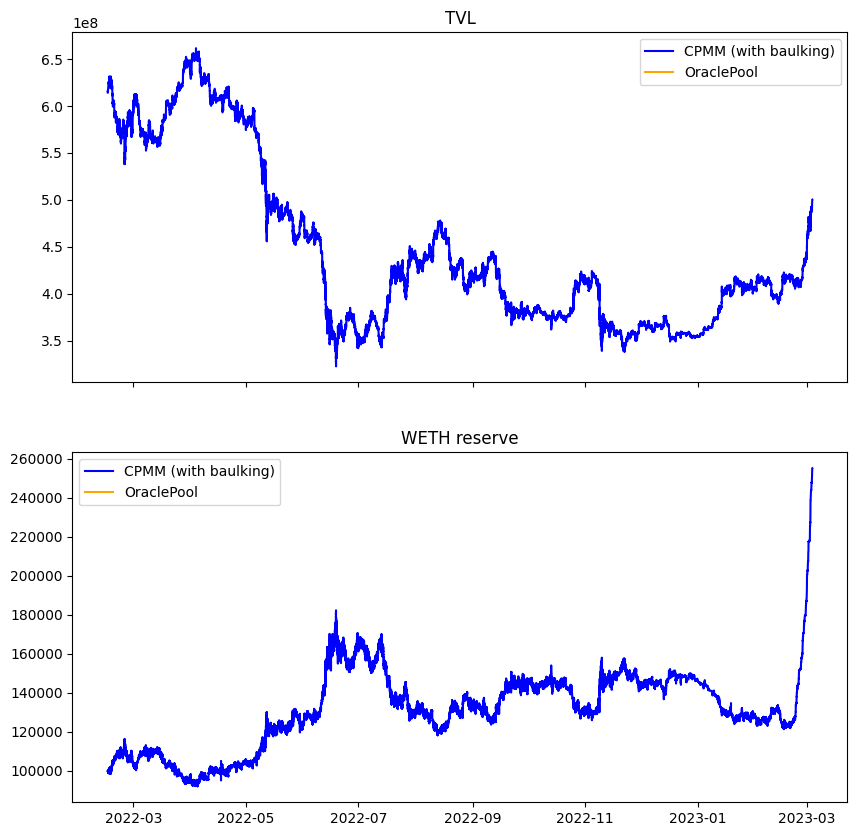

In [104]:
# plot subplots of merged dfs tvl
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax0.plot(results1_merged_df['ts'], results1_merged_df['tvl'], color='blue', label='CPMM (with baulking)')
ax0.plot(results2_merged_df['ts'], results2_merged_df['tvl'], color='orange', label='OraclePool')
ax0.set_title('TVL')
ax0.legend()
ax1.plot(results1_merged_df['ts'], results1_merged_df['reserve0'], color='blue', label='CPMM (with baulking)')
ax1.plot(results2_merged_df['ts'], results2_merged_df['reserve0'], color='orange', label='OraclePool')
ax1.set_title('WETH reserve')
ax1.legend()
plt.show();